In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn import cross_validation

# Prepare Data and Separate it into train and test sets

In [2]:
data = pd.read_csv('akutliggare.txt', sep='|')

In [3]:
data.head()

,PatientID,DokumentID,AkutliggareID,PasID,AnkomstsattID,ProblemorsakID,BesoksorsakID,ForstaBesoksorsakID,FlyttadTillVardenhetID,FlyttadTillLokationID,...,AntalAvlidnaInom7Dagar,AntalAvlidnaInom30Dagar,AntalSlutenvardInom6Timmar,AntalSlutenvardInom12Timmar,AntalDiagnoserOppenvard,AntalDiagnoserSlutenvard,AntalDiagnoser,Alder,SenastUppdaterad,AntalOvernattningar
0,-9220869629625426145,6,1,373,3266,3795,6863,6863,335,NaN,...,0,0,1,1,0,3,3,50,2014-07-29 23:23:08.000,0
1,-9220049438171032127,6,2,463,3272,3795,1908,1908,NaN,-92,...,0,0,0,0,0,NaN,0,"0,49039700000000003",2014-02-15 22:33:42.000,0
2,-9216200646992851360,6,313724,2804369,3272,3795,3213,3213,NaN,-91,...,0,0,0,0,1,NaN,1,"6,4931369999999999",2013-05-11 22:01:06.000,0
3,-9210158571153385697,6,313725,2804882,3272,3261,3172,6881,NaN,-91,...,0,0,0,0,1,NaN,1,"31,657516000000001",2013-10-20 20:53:17.000,0
4,-9209910299446293692,6,313726,2804897,3272,3260,6849,6849,NaN,-91,...,0,0,0,0,1,NaN,1,"21,958877000000001",2013-09-07 00:31:40.000,0


In [4]:
first_care_unit = data.ForstaSlutenvardVardenhetID

data['Inpatient'] = ~first_care_unit.isnull() & (first_care_unit != 0)

In [5]:
input_columns = ['AndningsfrekvensStatusID', 'SaturationStatusID', 'KroppstemperaturStatusID', 
                   'BlodtryckSystolisktOvreStatusID', 'BlodtryckDiastolisktNedreStatusID', 'GCSOgonoppningStatusID',
                   'GCSMotorisktStatusID', 'GCSVerbaltStatusID', 'StridorStatusID', 'PulsfrekvensRegelbundenStatusID',
                   'PulsfrekvensOregelbundenStatusID', 'MedvetandegradRettsStatusID', 'SaturationMedSyrgasStatusID',
                   'Alder']

output_column = 'Inpatient'

In [6]:
data['Alder'] = data.Alder.map(lambda a: float(str(a).replace(',', '.')))

for col in input_columns:
    is_null = data[col].isnull()
    data.loc[is_null, col] = -10

In [7]:
np.random.seed(921)
mask = np.random.choice([0, 1], data.shape[0], p=[0.1, 0.9])

test_data = data[mask == 0].copy()
train_data = data[mask == 1].copy()

# EDA

In [8]:
train_data[input_columns].describe()

,AndningsfrekvensStatusID,SaturationStatusID,KroppstemperaturStatusID,BlodtryckSystolisktOvreStatusID,BlodtryckDiastolisktNedreStatusID,GCSOgonoppningStatusID,GCSMotorisktStatusID,GCSVerbaltStatusID,StridorStatusID,PulsfrekvensRegelbundenStatusID,PulsfrekvensOregelbundenStatusID,MedvetandegradRettsStatusID,SaturationMedSyrgasStatusID,Alder
count,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000
mean,-2.216665,3.936990,5.995642,4.483956,6.802857,-9.535688,-9.454795,-9.399919,5.206821,15.999135,-8.320015,16.175416,-9.029214,36.809782
std,6.233143,8.326046,10.033086,13.738789,16.257596,4.168803,4.861398,5.378215,23.329732,27.069971,9.948612,31.474653,8.180108,27.100202
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,11.769841
50%,2.000000,9.000000,12.000000,17.000000,21.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,34.095887
75%,2.000000,9.000000,12.000000,17.000000,23.000000,-10.000000,-10.000000,-10.000000,41.000000,44.000000,-10.000000,54.000000,-10.000000,58.901345
max,5.000000,9.000000,14.000000,19.000000,24.000000,28.000000,34.000000,39.000000,41.000000,47.000000,53.000000,57.000000,60.000000,113.983534


## Histograms of all predict columns

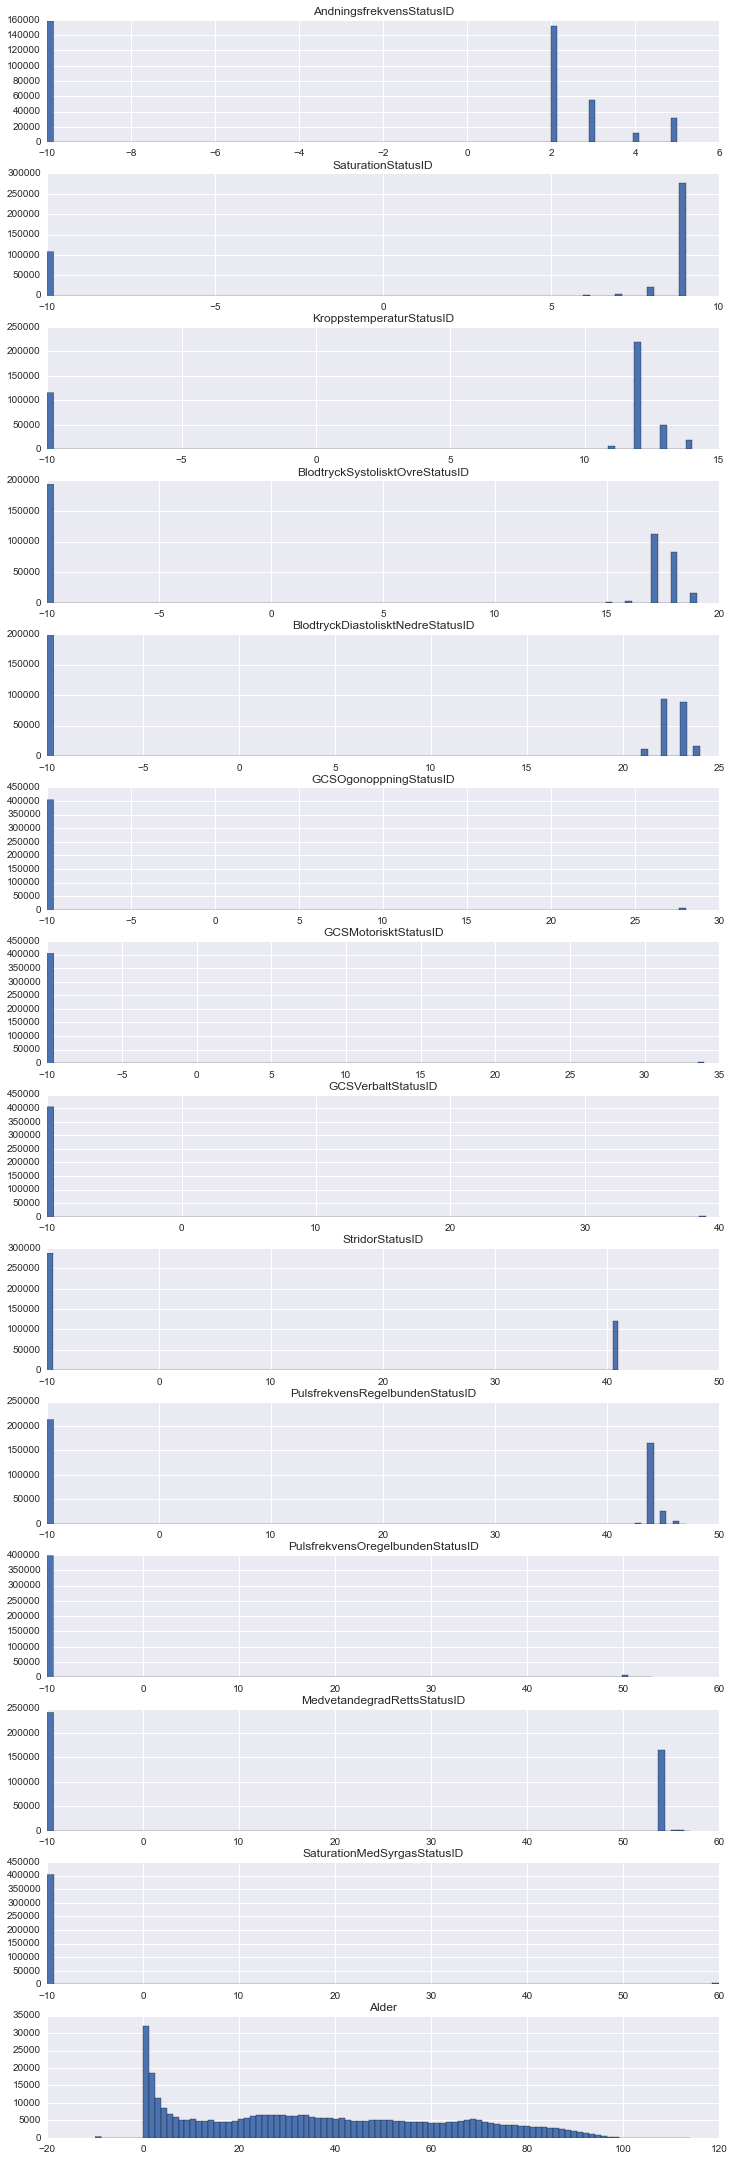

In [10]:
def plot_column(ax, col):
    ax.hist(train_data[col], bins=100)
    ax.set_title(col)

fig, axes = plt.subplots(nrows=len(input_columns), ncols=1, sharex=False, sharey=False, figsize=(10, 30))
fig.tight_layout()

for i, col in enumerate(input_columns):
    plot_column(axes[i], col)

## Pairplot